In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/Users/tanzinazaman/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


# Down-sampling and pre-processing

In [2]:
# Function to select and load top 10 cluster data
def load_top10cluster():
    parent_df = pd.read_csv('expedia_train.csv')
    top_cluster_list = dict(parent_df['hotel_cluster'].value_counts().head(10)).keys()
    sample_df = parent_df[parent_df['hotel_cluster'].isin(top_cluster_list)]
    #top_cluster_df.to_csv('top_10_cluster.csv')
    #sample_df = sample_df.drop(sample_df.columns[0], axis=1)
    df_lst =[parent_df]
    del df_lst
    return sample_df, top_cluster_list

In [3]:
sample_df, cluster_id = load_top10cluster()
print cluster_id
print sample_df.shape

[64, 65, 98, 59, 5, 41, 42, 48, 21, 91]
(6827550, 24)


In [4]:
#create more feature
sample_df["date_time"] = pd.to_datetime(sample_df["date_time"])
sample_df["year"] = sample_df["date_time"].dt.year
sample_df["month"] = sample_df["date_time"].dt.month
sample_df['day'] = sample_df["date_time"].dt.day
sample_df['day of week'] = sample_df["date_time"].dt.weekday

In [5]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(sample_df, test_size = 0.3)
print train.shape
print test.shape

(4779285, 28)
(2048265, 28)


# Fitting into Logistic regression model

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,roc_curve, auc, confusion_matrix
from sklearn.metrics import precision_recall_curve
# re-balance hotel cluster
def rebalance_sample():
    #cluster_probab = []
    probability = dict()
    
    class_accuracy = []
    class_precision = []
    class_f1_score = []
    class_recall = []
    
    cm = dict()
    fpr = dict()
    tpr = dict()
    thresholds = []
    a_u_c = dict()
    
    #pre_curve = dict()
    #recall_curve = dict()
    #area_precision_recall=dict()
    
    for i,val in enumerate(cluster_id):
        new_train = train.copy()
        new_test = test.copy()
        feature = ['posa_continent','user_location_country','user_location_region','user_location_city','user_id',
                   'srch_adults_cnt','srch_rm_cnt','srch_destination_id','is_booking','cnt','hotel_continent',
                   'hotel_country','hotel_market','year','month','day','day of week']
        #label = ['hotel_cluster']
        
        #train
        new_train.loc[new_train.hotel_cluster != val,'hotel_cluster'] = 0
        new_train.loc[new_train.hotel_cluster == val,'hotel_cluster'] = 1
        feature_train = new_train.loc[:,(feature)]
        label_train = new_train['hotel_cluster'].values
        
        # test
        new_test.loc[new_test.hotel_cluster != val,'hotel_cluster'] = 0
        new_test.loc[new_test.hotel_cluster == val,'hotel_cluster'] = 1
        feature_test = new_test.loc[:,(feature)]
        label_test = new_test['hotel_cluster'].values
        y_test = test.loc[:,(feature)]
        #y_test = test['hotel_cluster'].values
        #y_test = y_test.reshape(-1,1)
        
        #train model
        clf = SGDClassifier(loss = 'log', penalty = 'l2')
        clf = clf.fit(feature_train, label_train)
        #test model
        prediction = clf.predict(feature_test)
        
        #confusion matrix
        cm[i] = confusion_matrix(label_test,prediction)#, labels=["0", "1"])
        
        #calculate probability
        probability[i] = clf.predict_proba(y_test)
        #cluster_probab.append(probability)
        
        #evaluate model
        acc = round(accuracy_score(prediction,label_test),3)
        precision = precision_score(label_test,prediction,average=None)
        f1score = f1_score(label_test,prediction,average=None)
        recall = recall_score(label_test,prediction,average=None)
        fpr[i], tpr[i],thresh = roc_curve(label_test,prediction)
        a_u_c[i] = auc(fpr[i], tpr[i])
        
        #precision- recall curve
        #pre_curve[i], recall_curve[i] = precision_recall_curve(label_test,prediction)
        #area_precision_recall[i] = auc(pre_curve[i],recall_curve[i])
        #pre_curve_1, recall_curve_1 = precision_recall_curve(label_test,prediction)
        #pre_curve.append(pre_curve_1)
        #recall_curve.append(recall_curve_1)
        
        
        class_accuracy.append(acc)
        class_precision.append(precision)
        class_f1_score.append(f1score)
        class_recall.append(recall)
        thresholds.append(thresh)
        
    return cm, probability,class_accuracy,class_precision,class_f1_score,class_recall,fpr,tpr,thresholds,a_u_c 

In [18]:
cf_matrix, cluster_probab,metric_accuracy,metric_precision,metric_f1_score,metric_recall,metric_fpr,metric_tpr,thresholds,roc_auc= rebalance_sample()


# Evalution metrics 

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(iris.target_names))
    #plt.xticks(tick_marks, iris.target_names, rotation=45)
    #plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
print('Confusion matrix, without normalization\n')
for keys, val in cf_matrix.items():
    print 'Cluster order',keys
    print val, '\n'

Confusion matrix, without normalization

Cluster order 0
[[1738504   98702]
 [ 160426   50633]] 

Cluster order 1
[[1833975   13226]
 [ 199483    1581]] 

Cluster order 2
[[1868350    3299]
 [ 176467     149]] 

Cluster order 3
[[1874996    2228]
 [ 170516     525]] 

Cluster order 4
[[1858947    3068]
 [ 185080    1170]] 

Cluster order 5
[[1814911    1342]
 [ 231876     136]] 

Cluster order 6
[[1857857   24495]
 [ 163577    2336]] 

Cluster order 7
[[1820850     764]
 [ 226544     107]] 

Cluster order 8
[[1881404    1554]
 [ 165131     176]] 

Cluster order 9
[[1681007   54906]
 [ 301707   10645]] 



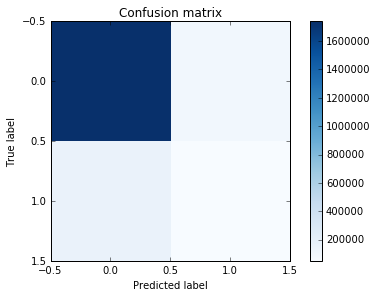

In [27]:
fig = plt.figure()
plot_confusion_matrix(cf_matrix[0])
fig.savefig('cmatrix1.png',bbox_inches='tight')

In [48]:
cluster_id

[64, 65, 98, 59, 5, 41, 42, 48, 21, 91]

In [51]:
print('Probability for each classifier\n')
for keys, val in cluster_probab.items():
    print 'Cluster order',keys
    print val, '\n'


Probability for each classifier

Cluster order 0
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 1
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 2
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 3
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 4
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 5
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 6
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 7
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 8
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 

Cluster order 9
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]] 



In [81]:
for i in metric_accuracy:
    print 'accuracy', i*100

accuracy 87.3
accuracy 89.6
accuracy 91.2
accuracy 91.6
accuracy 90.8
accuracy 88.6
accuracy 90.8
accuracy 88.9
accuracy 91.9
accuracy 82.6


In [53]:
metric_precision

[array([ 0.91551769,  0.33905648]),
 array([ 0.90189962,  0.10677382]),
 array([ 0.91370035,  0.04321346]),
 array([ 0.91663896,  0.19070105]),
 array([ 0.90945325,  0.27607362]),
 array([ 0.8867122 ,  0.09201624]),
 array([ 0.91907873,  0.08706347]),
 array([ 0.88935007,  0.1228473 ]),
 array([ 0.91931191,  0.1017341 ]),
 array([ 0.84783131,  0.16239264])]

In [54]:
metric_f1_score

[array([ 0.93064278,  0.28098692]),
 array([ 0.9451874 ,  0.01464764]),
 array([ 0.95409995,  0.00165497]),
 array([ 0.95596339,  0.00604164]),
 array([ 0.95183155,  0.01228424]),
 array([ 0.93962838,  0.00116493]),
 array([ 0.95182318,  0.02423941]),
 array([  9.41249023e-01,   9.40568385e-04]),
 array([ 0.95758104,  0.00210732]),
 array([ 0.9041009 ,  0.05633721])]

In [55]:
metric_recall

[array([ 0.94627603,  0.23989974]),
 array([ 0.99283998,  0.00786317]),
 array([  9.98237383e-01,   8.43638175e-04]),
 array([ 0.99881314,  0.00306944]),
 array([ 0.99835232,  0.00628188]),
 array([  9.99261116e-01,   5.86176577e-04]),
 array([ 0.98698702,  0.01407967]),
 array([  9.99580592e-01,   4.72091453e-04]),
 array([ 0.9991747 ,  0.00106469]),
 array([ 0.96837053,  0.03408014])]

In [56]:
metric_fpr

{0: array([ 0.        ,  0.05372397,  1.        ]),
 1: array([ 0.        ,  0.00716002,  1.        ]),
 2: array([ 0.        ,  0.00176262,  1.        ]),
 3: array([ 0.        ,  0.00118686,  1.        ]),
 4: array([ 0.        ,  0.00164768,  1.        ]),
 5: array([  0.00000000e+00,   7.38883845e-04,   1.00000000e+00]),
 6: array([ 0.        ,  0.01301298,  1.        ]),
 7: array([  0.00000000e+00,   4.19408283e-04,   1.00000000e+00]),
 8: array([  0.00000000e+00,   8.25297219e-04,   1.00000000e+00]),
 9: array([ 0.        ,  0.03162947,  1.        ])}

In [57]:
metric_tpr

{0: array([ 0.        ,  0.23989974,  1.        ]),
 1: array([ 0.        ,  0.00786317,  1.        ]),
 2: array([  0.00000000e+00,   8.43638175e-04,   1.00000000e+00]),
 3: array([ 0.        ,  0.00306944,  1.        ]),
 4: array([ 0.        ,  0.00628188,  1.        ]),
 5: array([  0.00000000e+00,   5.86176577e-04,   1.00000000e+00]),
 6: array([ 0.        ,  0.01407967,  1.        ]),
 7: array([  0.00000000e+00,   4.72091453e-04,   1.00000000e+00]),
 8: array([ 0.        ,  0.00106469,  1.        ]),
 9: array([ 0.        ,  0.03408014,  1.        ])}

In [58]:
roc_auc

{0: 0.5930878868443562,
 1: 0.50035157291869914,
 2: 0.49954051068001881,
 3: 0.50094129029867263,
 4: 0.50231710090643489,
 5: 0.49992364636607334,
 6: 0.50053334650169179,
 7: 0.50002634158519776,
 8: 0.50011969424373204,
 9: 0.5012253375264637}

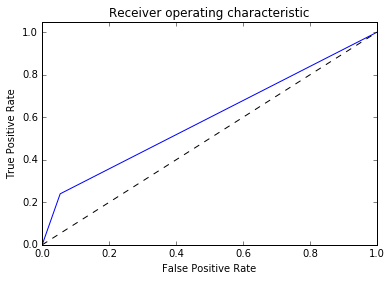

In [67]:
fig = plt.figure()
plt.plot(metric_fpr[0], metric_tpr[0])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc1.png',bbox_inches='tight')

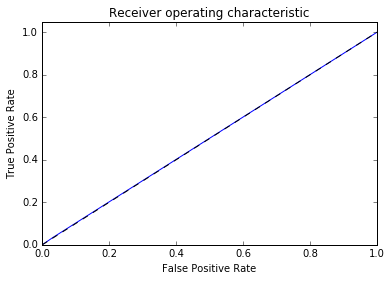

In [76]:
fig = plt.figure()
plt.plot(metric_fpr[9], metric_tpr[9])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
fig.savefig('roc10.png',bbox_inches='tight')

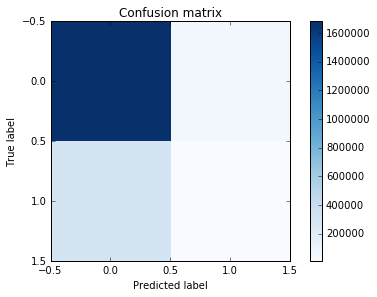

In [40]:
fig = plt.figure()
plot_confusion_matrix(cf_matrix[9])
fig.savefig('cmatrix10.png',bbox_inches='tight')